<a href="https://colab.research.google.com/github/RezuanChowdhuryRifat/Simple-GAN/blob/main/data_denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import os

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from google.colab import drive
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import glob

In [45]:
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:

os.makedirs("dataset/Radiographic_image")

In [ ]:
!cp "/content/drive/MyDrive/dataset/Radiographic Dataset-20220705T185450Z-001.zip" dataset/Radiographic_image.zip

In [ ]:
!unzip dataset/Radiographic_image.zip -d dataset/Radiographic_image


In [47]:
batch_size =32
image_size = 64
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
transform=transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

train_folder = datasets.ImageFolder(root="/content/dataset/Radiographic_image/Radiographic Dataset/panoramic sbj a12",transform=transform)

train_loader = torch.utils.data.DataLoader(train_folder,batch_size = batch_size, num_workers = 1, shuffle=True)


FileNotFoundError: ignored

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
from torchvision.utils import make_grid
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

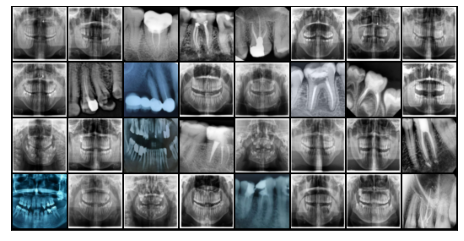

In [ ]:
show_batch(train_loader)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_loader, device)

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
latent_size = 128

generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [ ]:
generator = to_device(generator, device)

In [ ]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [ ]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [ ]:
from torchvision.utils import save_image
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


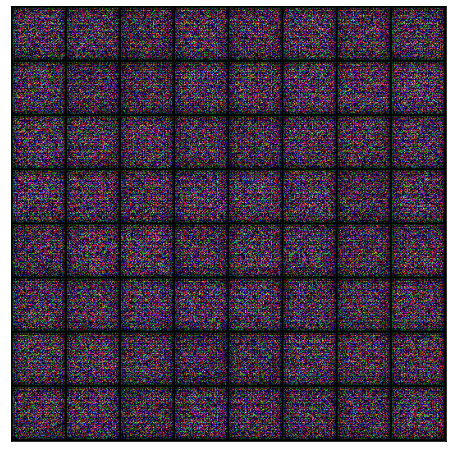

In [ ]:
save_samples(0, fixed_latent)

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
lr = 0.0002
epochs = 50

In [ ]:
history = fit(epochs, lr)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/50], loss_g: 8.4879, loss_d: 0.1563, real_score: 0.9497, fake_score: 0.0686
Saving generated-images-0001.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [2/50], loss_g: 11.8555, loss_d: 0.1820, real_score: 0.8735, fake_score: 0.0001
Saving generated-images-0002.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [3/50], loss_g: 13.7715, loss_d: 0.3495, real_score: 0.9773, fake_score: 0.2756
Saving generated-images-0003.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [4/50], loss_g: 15.5813, loss_d: 0.3098, real_score: 0.9826, fake_score: 0.2496
Saving generated-images-0004.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [5/50], loss_g: 14.3689, loss_d: 0.0390, real_score: 0.9634, fake_score: 0.0000
Saving generated-images-0005.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [6/50], loss_g: 11.0774, loss_d: 0.0202, real_score: 0.9805, fake_score: 0.0003
Saving generated-images-0006.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [7/50], loss_g: 7.3680, loss_d: 0.0148, real_score: 0.9944, fake_score: 0.0091
Saving generated-images-0007.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [8/50], loss_g: 3.5322, loss_d: 0.2332, real_score: 0.8173, fake_score: 0.0067
Saving generated-images-0008.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [9/50], loss_g: 15.9430, loss_d: 1.4596, real_score: 0.4602, fake_score: 0.0000
Saving generated-images-0009.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [10/50], loss_g: 14.1220, loss_d: 0.1688, real_score: 0.8944, fake_score: 0.0000
Saving generated-images-0010.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [11/50], loss_g: 2.3979, loss_d: 0.3154, real_score: 0.7859, fake_score: 0.0124
Saving generated-images-0011.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [12/50], loss_g: 5.2975, loss_d: 0.0603, real_score: 0.9895, fake_score: 0.0479
Saving generated-images-0012.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [13/50], loss_g: 3.6933, loss_d: 0.2386, real_score: 0.8194, fake_score: 0.0158
Saving generated-images-0013.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [14/50], loss_g: 6.0609, loss_d: 0.0780, real_score: 0.9664, fake_score: 0.0400
Saving generated-images-0014.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [15/50], loss_g: 4.9956, loss_d: 0.3460, real_score: 0.7394, fake_score: 0.0102
Saving generated-images-0015.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [16/50], loss_g: 5.1516, loss_d: 0.1908, real_score: 0.8894, fake_score: 0.0139
Saving generated-images-0016.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [17/50], loss_g: 2.9804, loss_d: 0.2227, real_score: 0.8705, fake_score: 0.0370
Saving generated-images-0017.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [18/50], loss_g: 4.0882, loss_d: 0.1638, real_score: 0.9904, fake_score: 0.1325
Saving generated-images-0018.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [19/50], loss_g: 5.6456, loss_d: 0.0554, real_score: 0.9766, fake_score: 0.0284
Saving generated-images-0019.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [20/50], loss_g: 4.8446, loss_d: 0.0560, real_score: 0.9707, fake_score: 0.0246
Saving generated-images-0020.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [21/50], loss_g: 9.2780, loss_d: 0.0862, real_score: 0.9923, fake_score: 0.0733
Saving generated-images-0021.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [22/50], loss_g: 6.1377, loss_d: 0.0163, real_score: 0.9975, fake_score: 0.0137
Saving generated-images-0022.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [23/50], loss_g: 6.8478, loss_d: 0.0370, real_score: 0.9969, fake_score: 0.0332
Saving generated-images-0023.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [24/50], loss_g: 5.9692, loss_d: 0.0165, real_score: 0.9946, fake_score: 0.0109
Saving generated-images-0024.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [25/50], loss_g: 15.8615, loss_d: 0.0466, real_score: 0.9562, fake_score: 0.0000
Saving generated-images-0025.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [26/50], loss_g: 6.6575, loss_d: 0.0531, real_score: 0.9913, fake_score: 0.0430
Saving generated-images-0026.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [27/50], loss_g: 5.2233, loss_d: 0.4194, real_score: 0.7513, fake_score: 0.0071
Saving generated-images-0027.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [28/50], loss_g: 3.0443, loss_d: 0.0932, real_score: 0.9676, fake_score: 0.0540
Saving generated-images-0028.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [29/50], loss_g: 3.6750, loss_d: 0.0293, real_score: 0.9811, fake_score: 0.0100
Saving generated-images-0029.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [30/50], loss_g: 4.6147, loss_d: 0.1211, real_score: 0.9576, fake_score: 0.0654
Saving generated-images-0030.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [31/50], loss_g: 3.6069, loss_d: 0.4667, real_score: 0.7237, fake_score: 0.0548
Saving generated-images-0031.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [32/50], loss_g: 5.5796, loss_d: 0.1050, real_score: 0.9121, fake_score: 0.0083
Saving generated-images-0032.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [33/50], loss_g: 4.3948, loss_d: 0.0817, real_score: 0.9729, fake_score: 0.0503
Saving generated-images-0033.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [34/50], loss_g: 3.5486, loss_d: 0.3172, real_score: 0.8829, fake_score: 0.1616
Saving generated-images-0034.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [35/50], loss_g: 3.0791, loss_d: 1.2550, real_score: 0.9812, fake_score: 0.5155
Saving generated-images-0035.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [36/50], loss_g: 4.3534, loss_d: 0.4042, real_score: 0.9415, fake_score: 0.2579
Saving generated-images-0036.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [37/50], loss_g: 3.3175, loss_d: 0.8725, real_score: 0.8180, fake_score: 0.3637
Saving generated-images-0037.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [38/50], loss_g: 0.2266, loss_d: 1.6104, real_score: 0.2758, fake_score: 0.0045
Saving generated-images-0038.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [39/50], loss_g: 4.4734, loss_d: 0.1041, real_score: 0.9655, fake_score: 0.0607
Saving generated-images-0039.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [40/50], loss_g: 2.8953, loss_d: 0.4620, real_score: 0.7702, fake_score: 0.1469
Saving generated-images-0040.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [41/50], loss_g: 4.2829, loss_d: 0.1401, real_score: 0.9889, fake_score: 0.1169
Saving generated-images-0041.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [42/50], loss_g: 11.4090, loss_d: 2.1383, real_score: 0.9969, fake_score: 0.8350
Saving generated-images-0042.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [43/50], loss_g: 6.6025, loss_d: 0.5000, real_score: 0.8435, fake_score: 0.2440
Saving generated-images-0043.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [44/50], loss_g: 2.8305, loss_d: 0.3855, real_score: 0.7900, fake_score: 0.1116
Saving generated-images-0044.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [45/50], loss_g: 5.7939, loss_d: 0.3263, real_score: 0.9859, fake_score: 0.2364
Saving generated-images-0045.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [46/50], loss_g: 2.6219, loss_d: 0.3381, real_score: 0.8284, fake_score: 0.1155
Saving generated-images-0046.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [47/50], loss_g: 3.4759, loss_d: 0.1382, real_score: 0.9863, fake_score: 0.1114
Saving generated-images-0047.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [48/50], loss_g: 3.6491, loss_d: 0.1542, real_score: 0.9361, fake_score: 0.0780
Saving generated-images-0048.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [49/50], loss_g: 4.4607, loss_d: 0.3515, real_score: 0.7767, fake_score: 0.0247
Saving generated-images-0049.png


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [50/50], loss_g: 3.7249, loss_d: 0.4194, real_score: 0.9749, fake_score: 0.2262
Saving generated-images-0050.png


In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [ ]:
from IPython.display import Image

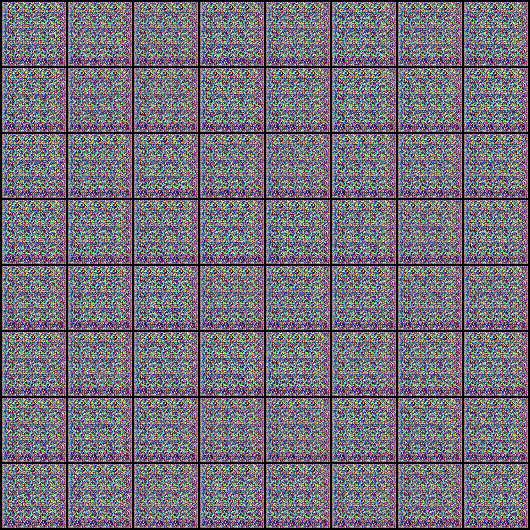

In [ ]:
Image('./generated/generated-images-0001.png')

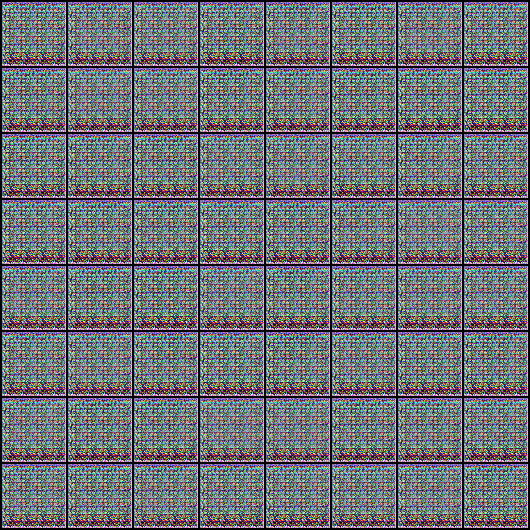

In [ ]:
Image('./generated/generated-images-0005.png')

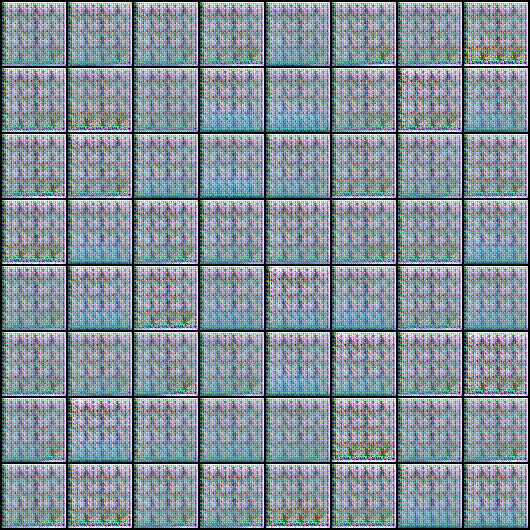

In [ ]:
Image('./generated/generated-images-0025.png')

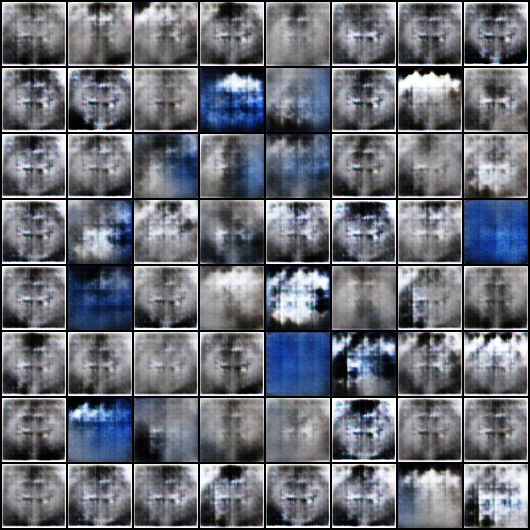

In [ ]:
Image('./generated/generated-images-0050.png')

In [ ]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

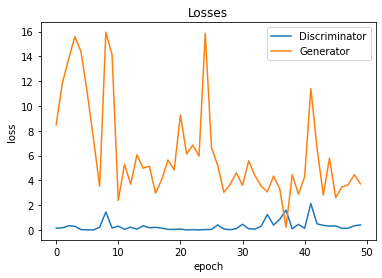

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

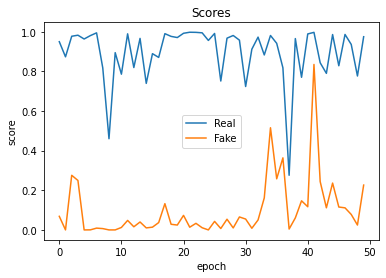

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');